In [1]:
! pip install tensorflow tensorflow-datasets mediapipe

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.core import base_options as mp_base_options
from mediapipe import Image as MPImage
from mediapipe import ImageFormat as MPImageFormat

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
import joblib

import cv2
import os
import requests

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:
# Load dataset with splits
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True
)
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
print('Train:', ds_info.splits['train'].num_examples * 0.8)
print('Val:', ds_info.splits['train'].num_examples * 0.2)
print('Test:', ds_info.splits['test'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.OHWRPW_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.OHWRPW_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Train: 2016.0
Val: 504.0
Test: 372


In [4]:
# Alternative dataset (hagrid sample)

!wget https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
!unzip rps_data_sample.zip
dataset_path = "rps_data_sample"

--2025-12-09 20:48:13--  https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12332447 (12M) [application/zip]
Saving to: ‘rps_data_sample.zip’

rps_data_sample.zip 100%[===================>]  11.76M  78.3MB/s    in 0.2s    

2025-12-09 20:48:13 (78.3 MB/s) - ‘rps_data_sample.zip’ saved [12332447/12332447]

Archive:  rps_data_sample.zip
   creating: rps_data_sample/
   creating: rps_data_sample/paper/
   creating: rps_data_sample/rock/
   creating: rps_data_sample/scissors/
   creating: rps_data_sample/none/
  inflating: rps_data_sample/paper/77.jpg  
  inflating: rps_data_sample/paper/837.jpg  
  inflating: rps_data_sample/paper/176.jpg  
  inflating: rps_data_sample/paper/406.jpg  
  infl

rps_data_sample
['rock', 'none', 'paper', 'scissors']
rock: 125 samples
none: 125 samples
paper: 125 samples
scissors: 125 samples


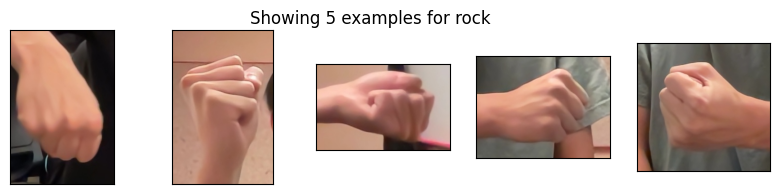

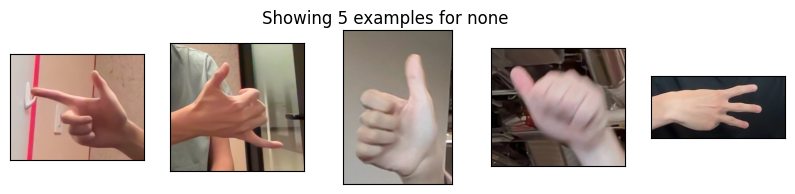

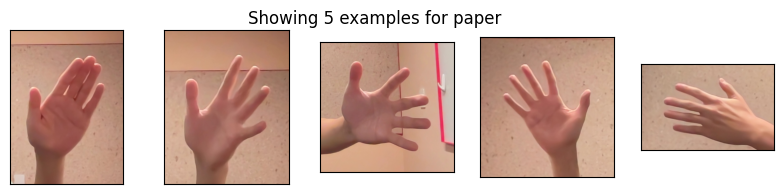

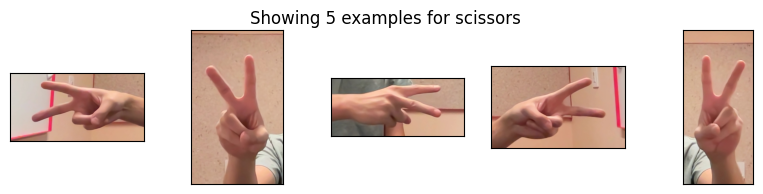

In [ ]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)



NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  num_samples = len(os.listdir(label_dir))
  print(f'{label}: {num_samples} samples')
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()



In [7]:
# Convert hagrid sample dataset to TensorFlow dataset format
def load_images_from_folder(folder_path, label_idx):
  """Load images from a folder and return as list of (image, label) tuples"""
  images = []
  labels_list = []
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
  for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)
    if img is not None:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (300, 300))  # Resize to match original dataset
      images.append(img)
      labels_list.append(label_idx)
  return images, labels_list

# Map hagrid labels to class indices (include 'none' as a new class)
hagrid_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2, 'none': 3}

all_images = []
all_labels = []

for label in labels:
  if label in hagrid_to_idx:
    label_dir = os.path.join(dataset_path, label)
    images, labels_list = load_images_from_folder(label_dir, hagrid_to_idx[label])
    all_images.extend(images)
    all_labels.extend(labels_list)

# Convert to numpy arrays
all_images = np.array(all_images, dtype=np.uint8)
all_labels = np.array(all_labels, dtype=np.int64)

print(f"Loaded {len(all_images)} images from hagrid sample dataset")

# Split into train/val/test (70%/15%/15%)
n_total = len(all_images)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

indices = np.random.permutation(n_total)
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

# Create TensorFlow datasets
hagrid_train_ds = tf.data.Dataset.from_tensor_slices((all_images[train_idx], all_labels[train_idx]))
hagrid_val_ds = tf.data.Dataset.from_tensor_slices((all_images[val_idx], all_labels[val_idx]))
hagrid_test_ds = tf.data.Dataset.from_tensor_slices((all_images[test_idx], all_labels[test_idx]))

# Concatenate with existing datasets
train_ds = train_ds.concatenate(hagrid_train_ds)
val_ds = val_ds.concatenate(hagrid_val_ds)
test_ds = test_ds.concatenate(hagrid_test_ds)

# Shuffle the combined datasets
train_ds = train_ds.shuffle(10000)
val_ds = val_ds.shuffle(1000)
test_ds = test_ds.shuffle(1000)

# Update num_classes and class_names to include 'none'
num_classes = 4
class_names = ['rock', 'paper', 'scissors', 'none']

print(f"Combined datasets created")
print(f"Updated num_classes: {num_classes}, class_names: {class_names}")

Loaded 500 images from hagrid sample dataset
Combined datasets created
Updated num_classes: 4, class_names: ['rock', 'paper', 'scissors', 'none']


In [8]:
MODEL_URL = "https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task"

# Download to memory
resp = requests.get(MODEL_URL, timeout=30)
resp.raise_for_status()
model_bytes = resp.content

# Create the landmarker from bytes (no file path needed)
base_options = mp_base_options.BaseOptions(model_asset_buffer=model_bytes)
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE,
)
hand_landmarker = vision.HandLandmarker.create_from_options(options)
print("Hand landmarker loaded from in-memory bytes")

Hand landmarker loaded from in-memory bytes


In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def extract_landmarks(image, label):
    # Convert tensor to numpy and ensure uint8
    img_np = image.numpy().astype(np.uint8)

    # Create MediaPipe Image
    mp_image = MPImage(image_format=MPImageFormat.SRGB, data=img_np)

    # Detect hand landmarks
    detection_result = hand_landmarker.detect(mp_image)

    # Extract landmarks (21 landmarks * 2 coordinates = 42 features)
    if detection_result.hand_landmarks and len(detection_result.hand_landmarks[0]) == 21:
        landmarks = detection_result.hand_landmarks[0]
        features = np.array([[lm.x, lm.y] for lm in landmarks], dtype=np.float32)
    else:
        # If no hand detected, return None to let us skip later
        features = None

    return features, label

# Process datasets
X_val, y_val = [], []
for i, (image, label) in enumerate(val_ds):
    if i%10==0:
        print(f'val : {i}/{len(val_ds)}')
    features, lbl = extract_landmarks(image, label)
    if features is None:
        continue  # skip samples with no detected hand
    X_val.append(features)
    y_val.append(tf.one_hot(lbl, depth=num_classes).numpy())
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

X_test, y_test = [], []
for i, (image, label) in enumerate(test_ds):
    if i%10==0:
        print(f'Test : {i}/{len(test_ds)}')
    features, lbl = extract_landmarks(image, label)
    if features is None:
        continue
    X_test.append(features)
    y_test.append(tf.one_hot(lbl, depth=num_classes).numpy())
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

X_train, y_train = [], []
for i, (image, label) in enumerate(train_ds):
    if i%10==0:
        print(f'train : {i}/{len(train_ds)}')
    features, lbl = extract_landmarks(image, label)
    if features is None:
        continue
    X_train.append(features)
    y_train.append(tf.one_hot(lbl, depth=num_classes).numpy())
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

val : 0/579
val : 10/579
val : 20/579
val : 30/579
val : 40/579
val : 50/579
val : 60/579
val : 70/579
val : 80/579
val : 90/579
val : 100/579
val : 110/579
val : 120/579
val : 130/579
val : 140/579
val : 150/579
val : 160/579
val : 170/579
val : 180/579
val : 190/579
val : 200/579
val : 210/579
val : 220/579
val : 230/579
val : 240/579
val : 250/579
val : 260/579
val : 270/579
val : 280/579
val : 290/579
val : 300/579
val : 310/579
val : 320/579
val : 330/579
val : 340/579
val : 350/579
val : 360/579
val : 370/579
val : 380/579
val : 390/579
val : 400/579
val : 410/579
val : 420/579
val : 430/579
val : 440/579
val : 450/579
val : 460/579
val : 470/579
val : 480/579
val : 490/579
val : 500/579
val : 510/579
val : 520/579
val : 530/579
val : 540/579
val : 550/579
val : 560/579
val : 570/579
Test : 0/447
Test : 10/447
Test : 20/447
Test : 30/447
Test : 40/447
Test : 50/447
Test : 60/447
Test : 70/447
Test : 80/447
Test : 90/447
Test : 100/447
Test : 110/447
Test : 120/447
Test : 130/447


In [10]:
def preprocess_norm(landmarks):
    landmarks = np.array(landmarks, dtype=np.float32)

    # Rebase on wrist
    p0 = landmarks[0]
    landmarks = landmarks - p0

    # determine hand x axis
    vx, vy = (landmarks[17][0] - landmarks[5][0], landmarks[17][1] - landmarks[5][1])
    # guard degenerate axis
    eps = 1e-6
    if np.isfinite(vx) and np.isfinite(vy) and (abs(vx) > eps or abs(vy) > eps):
        theta = -np.arctan2(vy, vx)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s],[s,  c]], dtype=np.float32)
        landmarks = landmarks @ R.T

    # ensure palm faces upwards
    fingertip_indices = [8, 12, 16, 20]
    mean_y = np.mean(landmarks[fingertip_indices, 1])
    if np.isfinite(mean_y) and mean_y < 0:
        landmarks[:, 1] *= -1

    # normalize lengths (avoid divide by zero)
    scale = np.linalg.norm(landmarks[17] - landmarks[5]) + eps
    landmarks = landmarks / scale

    # sanitize
    landmarks = np.nan_to_num(landmarks, nan=0.0, posinf=0.0, neginf=0.0)

    return landmarks.reshape(-1).astype(np.float32)

In [11]:
# Apply preprocessing to all datasets
X_train_norm = np.array([preprocess_norm(landmarks) for landmarks in X_train])
X_val_norm = np.array([preprocess_norm(landmarks) for landmarks in X_val])
X_test_norm = np.array([preprocess_norm(landmarks) for landmarks in X_test])

X_train_norm = np.nan_to_num(X_train_norm, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
X_val_norm   = np.nan_to_num(X_val_norm,   nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
X_test_norm  = np.nan_to_num(X_test_norm,  nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_val_norm shape: {X_val_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")

X_train_norm shape: (2234, 42)
X_val_norm shape: (557, 42)
X_test_norm shape: (434, 42)


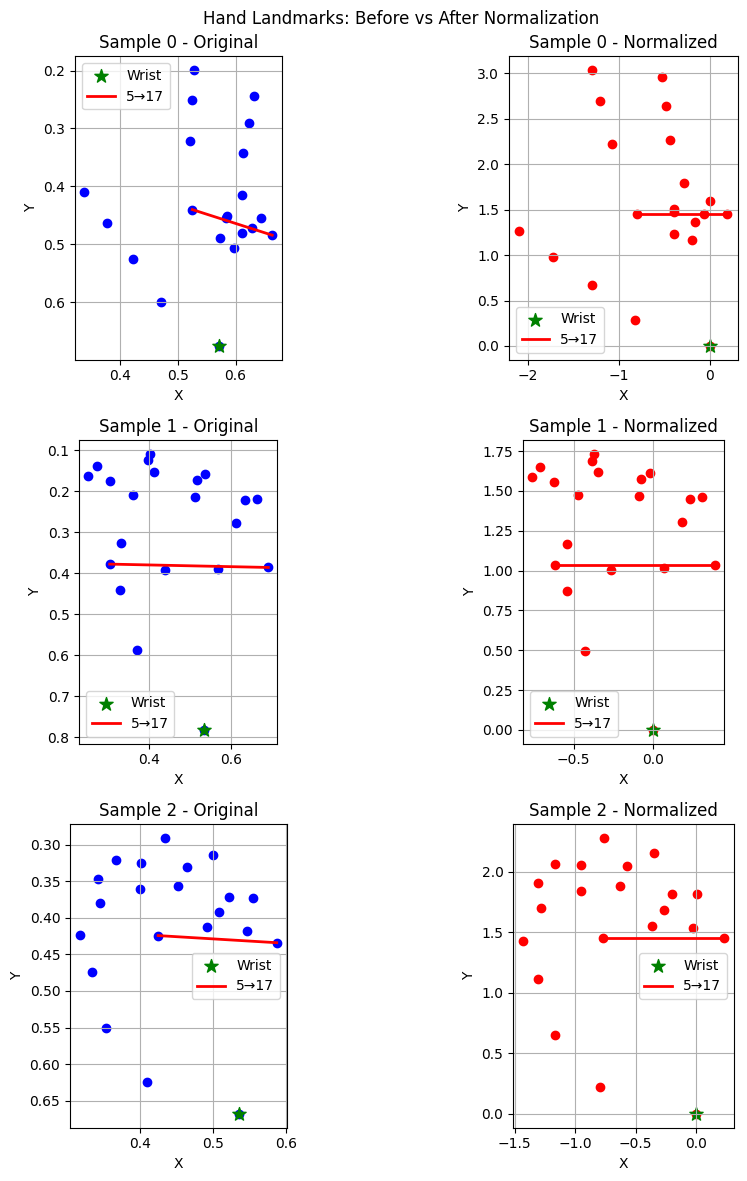

In [12]:
# Visualize before/after for a few samples
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('Hand Landmarks: Before vs After Normalization')

for i in range(3):
    # Before normalization
    landmarks_before = X_train[i].reshape(21, 2)
    axes[i, 0].scatter(landmarks_before[:, 0], landmarks_before[:, 1], c='blue')
    # Highlight wrist (landmark 0)
    axes[i, 0].scatter(landmarks_before[0, 0], landmarks_before[0, 1], c='green', s=100, marker='*', label='Wrist')
    # Draw line from landmark 5 to landmark 17
    axes[i, 0].plot([landmarks_before[5, 0], landmarks_before[17, 0]], 
                    [landmarks_before[5, 1], landmarks_before[17, 1]], 'r-', linewidth=2, label='5→17')
    axes[i, 0].set_title(f'Sample {i} - Original')
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_aspect('equal')
    axes[i, 0].grid(True)
    axes[i, 0].legend()
    
    # After normalization
    landmarks_after = X_train_norm[i].reshape(21, 2)
    axes[i, 1].scatter(landmarks_after[:, 0], landmarks_after[:, 1], c='red')
    # Highlight wrist (landmark 0)
    axes[i, 1].scatter(landmarks_after[0, 0], landmarks_after[0, 1], c='green', s=100, marker='*', label='Wrist')
    # Draw line from landmark 5 to landmark 17
    axes[i, 1].plot([landmarks_after[5, 0], landmarks_after[17, 0]], 
                    [landmarks_after[5, 1], landmarks_after[17, 1]], 'r-', linewidth=2, label='5→17')
    axes[i, 1].set_title(f'Sample {i} - Normalized')
    axes[i, 1].set_xlabel('X')
    axes[i, 1].set_ylabel('Y')
    # axes[i, 1].invert_yaxis()
    axes[i, 1].set_aspect('equal')
    axes[i, 1].grid(True)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [13]:
# Define, train and evaluate a simple MLP classifier on the preprocessed landmark vectors
input_dim = X_train_norm.shape[1]  # should be 42
print("Input dim:", input_dim, "Num classes:", num_classes)


model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

Input dim: 42 Num classes: 4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,212 (211.77 KB)

 Trainable params: 53,316 (208.27 KB)

 Non-trainable params: 896 (3.50 KB)

In [14]:
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=100,
    batch_size=32,
    callbacks=cb,
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Epoch 1/100


70/70 - 4s - 56ms/step - accuracy: 0.8796 - loss: 0.3711 - val_accuracy: 0.7379 - val_loss: 0.7581 - learning_rate: 0.0010
Epoch 2/100
70/70 - 0s - 6ms/step - accuracy: 0.9552 - loss: 0.1516 - val_accuracy: 0.8312 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 3/100
70/70 - 0s - 6ms/step - accuracy: 0.9646 - loss: 0.1160 - val_accuracy: 0.9659 - val_loss: 0.1927 - learning_rate: 0.0010
Epoch 4/100
70/70 - 0s - 6ms/step - accuracy: 0.9749 - loss: 0.0898 - val_accuracy: 0.9695 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 5/100
70/70 - 0s - 6ms/step - accuracy: 0.9745 - loss: 0.0972 - val_accuracy: 0.9767 - val_loss: 0.0789 - learning_rate: 0.0010
Epoch 6/100
70/70 - 0s - 6ms/step - accuracy: 0.9682 - loss: 0.0957 - val_accuracy: 0.9785 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 7/100
70/70 - 0s - 6ms/step - accuracy: 0.9731 - loss: 0.0918 - val_accuracy: 0.9138 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 8/100
70/70 - 0s - 6ms/step - accuracy: 0.9808 - loss: 0.0623 - val

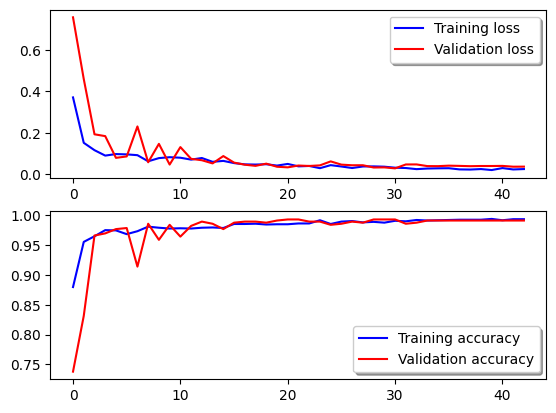

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
if 'val_loss' in history.history:
    ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history.get('accuracy', []), color='b', label="Training accuracy")
if 'val_accuracy' in history.history:
    ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
              precision    recall  f1-score   support

        rock       1.00      0.99      1.00       128
       paper       1.00      1.00      1.00       150
    scissors       0.99      0.98      0.98       143
        none       0.73      0.85      0.79        13

    accuracy                           0.99       434
   macro avg       0.93      0.95      0.94       434
weighted avg       0.99      0.99      0.99       434



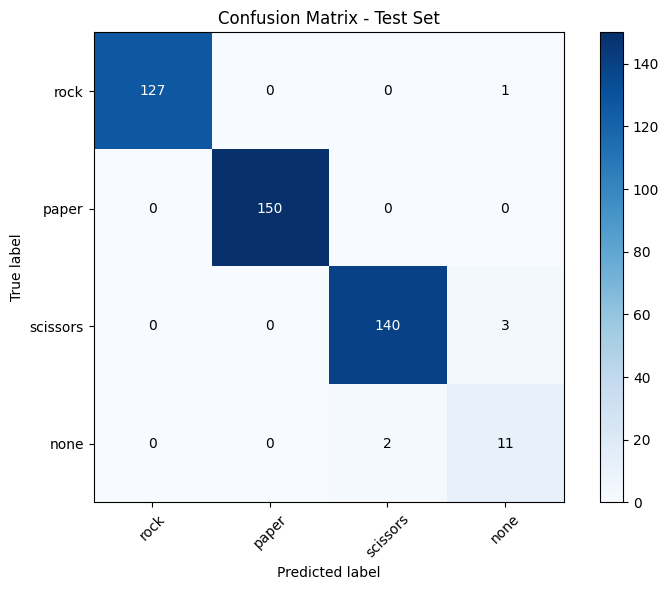

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Validate model on the test set
y_pred = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [20]:
# Save the model in Keras 3 format
model.save('hand_gesture_model.keras')
print("Model saved as 'hand_gesture_model.keras'")

Model saved as 'hand_gesture_model.keras'


In [ ]:
input_dim = X_train_norm.shape[1]  # 42
print("Input dim:", input_dim, "Num classes:", num_classes)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    batch_size=32,
    max_iter=200,              # roughly comparable to 100 epochs
    early_stopping=True,       # sklearn handles val split internally
    validation_fraction=0.1,
    n_iter_no_change=12,       # similar to Keras EarlyStopping patience=12
    verbose=True
)

# ---------------------- TRAINING ----------------------
mlp.fit(X_train_norm, np.argmax(y_train, axis=1))  # sklearn expects class indices

# ---------------------- EVALUATION ----------------------
y_pred = mlp.predict(X_test_norm)
y_proba = mlp.predict_proba(X_test_norm)

test_acc = accuracy_score(np.argmax(y_test, axis=1), y_pred)
test_loss = log_loss(np.argmax(y_test, axis=1), y_proba)

print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# ---------------------- SAVE MODEL ----------------------
joblib.dump(mlp, "gesture_mlp_sklearn.joblib")
print("Model saved as gesture_mlp_sklearn.joblib")